# NEXT WEEK

Compare again to deep fields, look at middling magnitudes with low misclassification rates. Try to quantify what is "good enough" and when the program starts breaking down.

In [1]:
import numpy as np
import fitsio
import astropy.io.fits as fits
from astropy.table import Table
import healpy as hp
from GetObjects import *
from PreTrainingMethods import *
from GalaxyMethods import *
from StarMethods import *
import Config

### Hyper Parameters

In [2]:
minGR = -0.3 # Minimum G-R color
maxGR = 1 # Maximum G-R color
res = 512 # Healpixel resolution
perCovered = 0.6 # Percent of healpixel that must have valid survey properties at the 4096 scale
sigma = 0.5 # Sigma used for gaussian weighting
numBins = 100 # Number of bins to use
perVar = 0.98 # Percent of the variance to be captured
perMap = 0.625 # Percent of the PC maps to use, adjust this later
magBins = [20, 22, 23, 24, 25, 26] # G magnitude bins
numBins = 100 # Number of points in interpolation

### Files

#### Conditions and File for Storage

In [3]:
conditions = Config.conditions
galaDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/GalaxyContamination/'

#### Deep Field Data

In [4]:
deepFiles = ['/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000001.fits', 
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000002.fits', 
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000003.fits',
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000004.fits',
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000005.fits']

#### File of Balrog and Location for Galaxy Information Storage

In [5]:
balrFile = '/hdfs/bechtol/balrog/y3/balrog_detection_catalog_sof_y3-merged_v1.2.fits'
measBalrFile = '/hdfs/bechtol/balrog/y3/balrog_matched_catalog_sof_y3-merged_v1.2.fits'
galaFile = galaDir + 'Blue_Galaxies.fits'
measGalaFile = galaDir + 'Blue_Meas_Galaxies.fits'

#### File of Delta Star Files and Location of Different Star Information Storages
NoDel means that the stars are not delta stars but instead pulled from the deep fields. Meas means that the star magnitude information is from the measured result, not the true number. Meas stars cannot be used for star detection probabilities but only misclassification.

In [6]:
balrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
starFile = galaDir + 'Blue_Stars.fits'
starNoDelFile = galaDir + 'Blue_No_Del_Stars.fits'

measBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_matched_catalog_sof_run2_stars_v1.4.fits'
measStarFile = galaDir + 'Blue_Meas_Stars.fits'

#### Original Location of Conditions and New Condition Information Storage

In [7]:
origCondFiles = Config.files[:-1]
stelFile = Config.files[-1]
pixFile = galaDir + 'Valid_'+str(res)+'_Pixels.fits'
condFiles = []
for cond in conditions:
    condFiles.append(galaDir + str(res) + '_' + cond + '.fits')
condFiles = np.array(condFiles)

#### Location of Galaxy Probabilities

In [8]:
galaExtrFiles = [galaDir + 'Gala_Extr_<20.fits', galaDir + 'Gala_Extr_20-22.fits', galaDir + 'Gala_Extr_22-23.fits',
                 galaDir + 'Gala_Extr_23-24.fits', galaDir + 'Gala_Extr_24-25.fits', galaDir + 'Gala_Extr_25-26.fits',
                 galaDir + 'Gala_Extr_>26.fits']
galaTrainFiles = [galaDir + 'Gala_Train_<20.fits', galaDir + 'Gala_Train_20-22.fits', galaDir + 'Gala_Train_22-23.fits',
                  galaDir + 'Gala_Train_23-24.fits', galaDir + 'Gala_Train_24-25.fits', galaDir + 'Gala_Train_25-26.fits',
                  galaDir + 'Gala_Train_>26.fits']
galaProbFiles = [galaDir + 'Gala_Prob_<20.fits', galaDir + 'Gala_Prob_20-22.fits', galaDir + 'Gala_Prob_22-23.fits',
                 galaDir + 'Gala_Prob_23-24.fits', galaDir + 'Gala_Prob_24-25.fits', galaDir + 'Gala_Prob_25-26.fits',
                 galaDir + 'Gala_Prob_>26.fits']

### Location of Measured Galaxy Misclassification Probabilities

In [9]:
galaMeasExtrFiles = [galaDir + 'Gala_Meas_Extr_<20.fits', galaDir + 'Gala_Meas_Extr_20-22.fits', galaDir + 'Gala_Meas_Extr_22-23.fits',
                 galaDir + 'Gala_Meas_Extr_23-24.fits', galaDir + 'Gala_Meas_Extr_24-25.fits', galaDir + 'Gala_Meas_Extr_25-26.fits',
                 galaDir + 'Gala_Meas_Extr_>26.fits']
galaMeasTrainFiles = [galaDir + 'Gala_Meas_Train_<20.fits', galaDir + 'Gala_Meas_Train_20-22.fits', galaDir + 'Gala_Meas_Train_22-23.fits',
                  galaDir + 'Gala_Meas_Train_23-24.fits', galaDir + 'Gala_Meas_Train_24-25.fits', galaDir + 'Gala_Meas_Train_25-26.fits',
                  galaDir + 'Gala_Meas_Train_>26.fits']
galaMeasProbFiles = [galaDir + 'Gala_Meas_Prob_<20.fits', galaDir + 'Gala_Meas_Prob_20-22.fits', galaDir + 'Gala_Meas_Prob_22-23.fits',
                 galaDir + 'Gala_Meas_Prob_23-24.fits', galaDir + 'Gala_Meas_Prob_24-25.fits', galaDir + 'Gala_Meas_Prob_25-26.fits',
                 galaDir + 'Gala_Meas_Prob_>26.fits']

#### Location of Star Misclassification Information and Detection Rates

In [10]:
starExtrFiles = [galaDir + 'Star_Extr_<20.fits', galaDir + 'Star_Extr_20-22.fits', galaDir + 'Star_Extr_22-23.fits',
                 galaDir + 'Star_Extr_23-24.fits', galaDir + 'Star_Extr_24-25.fits', galaDir + 'Star_Extr_25-26.fits',
                 galaDir + 'Star_Extr_>26.fits']
starTrainFiles = [galaDir + 'Star_Train_<20.fits', galaDir + 'Star_Train_20-22.fits', galaDir + 'Star_Train_22-23.fits',
                  galaDir + 'Star_Train_23-24.fits', galaDir + 'Star_Train_24-25.fits', galaDir + 'Star_Train_25-26.fits',
                  galaDir + 'Star_Train_>26.fits']
starProbFiles = [galaDir + 'Star_Prob_<20.fits', galaDir + 'Star_Prob_20-22.fits', galaDir + 'Star_Prob_22-23.fits',
                 galaDir + 'Star_Prob_23-24.fits', galaDir + 'Star_Prob_24-25.fits', galaDir + 'Star_Prob_25-26.fits',
                 galaDir + 'Star_Prob_>26.fits']

In [11]:
starDetExtrFiles = [galaDir + 'Star_Det_Extr_<20.fits', galaDir + 'Star_Det_Extr_20-22.fits', galaDir + 'Star_Det_Extr_22-23.fits',
                 galaDir + 'Star_Det_Extr_23-24.fits', galaDir + 'Star_Det_Extr_24-25.fits', galaDir + 'Star_Det_Extr_25-26.fits',
                 galaDir + 'Star_Det_Extr_>26.fits']
starDetTrainFiles = [galaDir + 'Star_Det_Train_<20.fits', galaDir + 'Star_Det_Train_20-22.fits', galaDir + 'Star_Det_Train_22-23.fits',
                  galaDir + 'Star_Det_Train_23-24.fits', galaDir + 'Star_Det_Train_24-25.fits', galaDir + 'Star_Det_Train_25-26.fits',
                  galaDir + 'Star_Det_Train_>26.fits']
starDetProbFiles = [galaDir + 'Star_Det_Prob_<20.fits', galaDir + 'Star_Det_Prob_20-22.fits', galaDir + 'Star_Det_Prob_22-23.fits',
                 galaDir + 'Star_Det_Prob_23-24.fits', galaDir + 'Star_Det_Prob_24-25.fits', galaDir + 'Star_Det_Prob_25-26.fits',
                 galaDir + 'Star_Det_Prob_>26.fits']

#### Location of Non Delta Star Misclassification Information and Detection Rates

In [12]:
starNoDelExtrFiles = [galaDir + 'Star_No_Del_Extr_<20.fits', galaDir + 'Star_No_Del_Extr_20-22.fits', galaDir + 'Star_No_Del_Extr_22-23.fits',
                 galaDir + 'Star_No_Del_Extr_23-24.fits', galaDir + 'Star_No_Del_Extr_24-25.fits', galaDir + 'Star_No_Del_Extr_25-26.fits',
                 galaDir + 'Star_No_Del_Extr_>26.fits']
starNoDelTrainFiles = [galaDir + 'Star_No_Del_Train_<20.fits', galaDir + 'Star_No_Del_Train_20-22.fits', galaDir + 'Star_No_Del_Train_22-23.fits',
                  galaDir + 'Star_No_Del_Train_23-24.fits', galaDir + 'Star_No_Del_Train_24-25.fits', galaDir + 'Star_No_Del_Train_25-26.fits',
                  galaDir + 'Star_No_Del_Train_>26.fits']
starNoDelProbFiles = [galaDir + 'Star_No_Del_Prob_<20.fits', galaDir + 'Star_No_Del_Prob_20-22.fits', galaDir + 'Star_No_Del_Prob_22-23.fits',
                 galaDir + 'Star_No_Del_Prob_23-24.fits', galaDir + 'Star_No_Del_Prob_24-25.fits', galaDir + 'Star_No_Del_Prob_25-26.fits',
                 galaDir + 'Star_No_Del_Prob_>26.fits']

In [13]:
starNoDelDetExtrFiles = [galaDir + 'Star_No_Del_Det_Extr_<20.fits', galaDir + 'Star_No_Del_Det_Extr_20-22.fits', galaDir + 'Star_No_Del_Det_Extr_22-23.fits',
                 galaDir + 'Star_No_Del_Det_Extr_23-24.fits', galaDir + 'Star_No_Del_Det_Extr_24-25.fits', galaDir + 'Star_No_Del_Det_Extr_25-26.fits',
                 galaDir + 'Star_No_Del_Det_Extr_>26.fits']
starNoDelDetTrainFiles = [galaDir + 'Star_No_Del_Det_Train_<20.fits', galaDir + 'Star_No_Del_Det_Train_20-22.fits', galaDir + 'Star_No_Del_Det_Train_22-23.fits',
                  galaDir + 'Star_No_Del_Det_Train_23-24.fits', galaDir + 'Star_No_Del_Det_Train_24-25.fits', galaDir + 'Star_No_Del_Det_Train_25-26.fits',
                  galaDir + 'Star_No_Del_Det_Train_>26.fits']
starNoDelDetProbFiles = [galaDir + 'Star_No_Del_Det_Prob_<20.fits', galaDir + 'Star_No_Del_Det_Prob_20-22.fits', galaDir + 'Star_No_Del_Det_Prob_22-23.fits',
                 galaDir + 'Star_No_Del_Det_Prob_23-24.fits', galaDir + 'Star_No_Del_Det_Prob_24-25.fits', galaDir + 'Star_No_Del_Det_Prob_25-26.fits',
                 galaDir + 'Star_No_Del_Det_Prob_>26.fits']

#### Location of Measured Star Misclassification Information

In [14]:
starMeasExtrFiles = [galaDir + 'Star_Meas_Extr_<20.fits', galaDir + 'Star_Meas_Extr_20-22.fits', galaDir + 'Star_Meas_Extr_22-23.fits',
                 galaDir + 'Star_Meas_Extr_23-24.fits', galaDir + 'Star_Meas_Extr_24-25.fits', galaDir + 'Star_Meas_Extr_25-26.fits',
                 galaDir + 'Star_Meas_Extr_>26.fits']
starMeasTrainFiles = [galaDir + 'Star_Meas_Train_<20.fits', galaDir + 'Star_Meas_Train_20-22.fits', galaDir + 'Star_Meas_Train_22-23.fits',
                  galaDir + 'Star_Meas_Train_23-24.fits', galaDir + 'Star_Meas_Train_24-25.fits', galaDir + 'Star_Meas_Train_25-26.fits',
                  galaDir + 'Star_Meas_Train_>26.fits']
starMeasProbFiles = [galaDir + 'Star_Meas_Prob_<20.fits', galaDir + 'Star_Meas_Prob_20-22.fits', galaDir + 'Star_Meas_Prob_22-23.fits',
                 galaDir + 'Star_Meas_Prob_23-24.fits', galaDir + 'Star_Meas_Prob_24-25.fits', galaDir + 'Star_Meas_Prob_25-26.fits',
                 galaDir + 'Star_Meas_Prob_>26.fits']

### Getting Galaxy Objects

In [15]:
# getGalaxies(minGR, maxGR, deepFiles, balrFile, galaFile)

### Getting Measured Galaxy Objects

In [16]:
# getMeasGalaxies(minGR, maxGR, deepFiles, measBalrFile, balrFile, measGalaFile)

### Getting Star Objects

In [17]:
# getStars(minGR, maxGR, balrStarFile, starFile)

### Getting Non Delta Stars

In [18]:
# getStarsNoDel(minGR, maxGR, deepFiles, balrFile, starNoDelFile)

### Getting Measured Stars

In [19]:
# getMeasStars(minGR, maxGR, measBalrStarFile, balrStarFile, measStarFile)

### Getting Valid Pixels and Cropping Data

In [20]:
# validPixCropData(res, origCondFiles, stelFile, pixFile, condFiles, perCovered)

### Galaxy Probabilities

I'm starting with galaxy probabilities since these will in general be easier. This is due to the fact that the only probability I need to calculate is how likely it is that a galaxy that is detected will be classified as a star. I don't need to figure out the probability that a galaxy will just be picked up, which would essentially serve to double the computation time.

In [21]:
# galaTrain(galaFile, condFiles, pixFile, magBins, galaTrainFiles, galaProbFiles, galaExtrFiles, sigma, perMap, perVar, numBins, res)
for galaTrainFile in galaTrainFiles:
    print(loadtxt(galaTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9298580145505749
0.9560199431309158
0.9734857060918916
0.9542146065324053
0.9043317577378551
0.8753835245374016
0.8619877531794631


### Measured Galaxy Probabilities

In [22]:
# galaTrain(measGalaFile, condFiles, pixFile, magBins, galaMeasTrainFiles, galaMeasProbFiles, galaMeasExtrFiles, sigma, perMap, perVar, numBins, res)
for galaTrainFile in galaMeasTrainFiles:
    print(loadtxt(galaTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9351532210951192
0.9553489449017557
0.9758779983761174
0.9635135987555853
0.9050432090661259
0.8364036028307956
0.8127090301003345


### Star Correct Classification Probability

In [23]:
# starTrain(starNoDelFile, condFiles, pixFile, magBins, starNoDelTrainFiles, starNoDelProbFiles, starNoDelExtrFiles, sigma, perMap, perVar, numBins, res)
for starTrainFile in starTrainFiles:
    print(loadtxt(starTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9955786958006145
0.9835265082405311
0.9461105559354126
0.8315897009024007
0.5103743970599495
0.28183831672203763
0.11737089201877934


### Measured Star Correct Classification Probability

In [24]:
# starTrain(measStarFile, condFiles, pixFile, magBins, starMeasTrainFiles, starMeasProbFiles, starMeasExtrFiles, sigma, perMap, perVar, numBins, res)
for starMeasTrainFile in starMeasTrainFiles:
    print(loadtxt(starMeasTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9953365169377705
0.9813493286548598
0.9401516528881426
0.8161554095571206
0.5225229357798166
0.43173661099191946
0.4168452062131762


### Star Detection Probability

In [25]:
# starDetTrain(starNoDelFile, condFiles, pixFile, magBins, starNoDelDetTrainFiles, starNoDelDetProbFiles, starNoDelDetExtrFiles, sigma, perMap, perVar, numBins, res)
aveEff = []
for starDetTrainFile in starDetTrainFiles:
    aveEff.append(loadtxt(starDetTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))
    print(aveEff[-1])

0.9924440077254092
0.9898534976956799
0.980314311052447
0.9668739710993232
0.7510453204964964
0.10525855662892862
0.0027415420852452263


### Applying Corrections

At this point, the actual pipeline is effectively complete, this is just to see what results it gives. With the average percentages listed above, I will look only at the first five bins, which cuts off at a gMag of 25.

In [26]:
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
from os import listdir

In [27]:
dirStars = '/hdfs/bechtol/balrog/y3/y3a2_gold_v2p2_skim/healpixel2/'
files = listdir(dirStars)
usedCols = ['HPIX_4096', 'FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF', 'SOF_PSF_MAG_G', 'SOF_PSF_MAG_R', 'SOF_CM_MAG_G', 'SOF_CM_MAG_R']
validPix = fitsio.read(pixFile)['PIXEL']
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True
newMagBins = magBins[:-1]

### Magnitude Adjustments

Once new skim is done, adjust these magnitudes to read in SOF_PSF mags for objects classified as stars.

In [28]:
# STARPIX = []

# GALAPIX = []

# for i in range(len(newMagBins)):
    
#     magStarPix = []
#     magGalaPix = []
    
#     for file in files:
#         obsData = fitsio.read(dirStars + file, columns = usedCols)
#         FOREGROUND = obsData[usedCols[1]]
#         BADREGIONS = obsData[usedCols[2]]
#         FOOTPRINT = obsData[usedCols[3]]
#         CLASS = obsData[usedCols[4]]
#         GMAG = obsData[usedCols[5]]
#         RMAG = obsData[usedCols[6]]
#         GMAG_GALA = obsData[usedCols[7]]
#         RMAG_GALA = obsData[usedCols[8]]
        
#         if i == 0:
#             magCut = np.where(GMAG <= newMagBins[i])[0]
#         else:
#             magCut = np.where((GMAG <= newMagBins[i]) & (GMAG > newMagBins[i - 1]))[0]
        
#         boolMagCut = np.zeros(len(GMAG))
#         boolMagCut[magCut] = 1
        
#         if i == 0:
#             magCutGala = np.where(GMAG_GALA <= newMagBins[i])[0]
#         else:
#             magCutGala = np.where((GMAG_GALA <= newMagBins[i]) & (GMAG_GALA > newMagBins[i - 1]))[0]
        
#         boolMagCutGala = np.zeros(len(GMAG_GALA))
#         boolMagCutGala[magCutGala] = 1
        
#         # Observed Star Objects

#         blueStarCut = np.where((FOREGROUND == 0) & 
#                           (BADREGIONS < 2) & 
#                           (FOOTPRINT == 1) & 
#                           (CLASS <= 1) & 
#                           (CLASS >= 0) &
#                           (boolMagCut > 0) &
#                           ((GMAG - RMAG) <= maxGR) &
#                           ((GMAG - RMAG) >= minGR))[0]

#         thetaStar, phiStar = hp.pix2ang(4096, obsData[usedCols[0]][blueStarCut], nest = True, lonlat = True)

#         allStarPIX = hp.ang2pix(res, thetaStar, phiStar, nest = True, lonlat = True)

#         trimStarPIX = allStarPIX[np.where(pixCheck[allStarPIX])[0]]

#         magStarPix.extend(trimStarPIX)
        
#         # Observed Galaxy Objects
        
#         blueGalaCut = np.where((FOREGROUND == 0) & 
#                           (BADREGIONS < 2) & 
#                           (FOOTPRINT == 1) & 
#                           (CLASS <= 3) & 
#                           (CLASS >= 2) &
#                           (boolMagCutGala > 0) &
#                           ((GMAG_GALA - RMAG_GALA) <= maxGR) &
#                           ((GMAG_GALA - RMAG_GALA) >= minGR))[0]

#         thetaGala, phiGala = hp.pix2ang(4096, obsData[usedCols[0]][blueGalaCut], nest = True, lonlat = True)

#         allGalaPIX = hp.ang2pix(res, thetaGala, phiGala, nest = True, lonlat = True)

#         trimGalaPIX = allGalaPIX[np.where(pixCheck[allGalaPIX])[0]]

#         magGalaPix.extend(trimGalaPIX)
        
#     STARPIX.append(np.array(magStarPix))
    
#     GALAPIX.append(np.array(magGalaPix))
    
# STARPIX = np.array(STARPIX, dtype = object)

# GALAPIX = np.array(GALAPIX, dtype = object)

In [29]:
obsStarFiles = [galaDir + 'Obs_Star_<20.fits', galaDir + 'Obs_Star_20-22.fits', galaDir + 'Obs_Star_22-23.fits',
                 galaDir + 'Obs_Star_23-24.fits', galaDir + 'Obs_Star_24-25.fits', galaDir + 'Obs_Star_25-26.fits']

In [30]:
# for i in range(len(newMagBins)):
    
#     starPixRepeats = STARPIX[i]
#     sortInds = starPixRepeats.argsort()
#     starPixRepeats = starPixRepeats[sortInds[::1]]
    
#     # These are indices that will be looping through the pixStar and starPix arrays in parallel.
#     uniqInd = 0
#     starInd = 0

#     # This will be used to store the number of stars at each pixel.
#     starPix = np.unique(starPixRepeats) # The unique pixels, with no repeats.
#     starDet = np.zeros_like(starPix)

#     while starInd < len(starPixRepeats):
#         if starPix[uniqInd] == starPixRepeats[starInd]: # If the pixels match up in the arrays.
#             starDet[uniqInd] += 1                # Add one for the detection..
#             starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
#             # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
#             # making this the index that we must restrict in the while loop.
#         else:
#             uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.
            
#     fullSkyStars = np.full(12*(res**2), 0.0)
#     fullSkyStars[starPix] = starDet
    
#     my_table = Table()
#     my_table['SIGNAL'] = fullSkyStars[validPix]
#     my_table.write(obsStarFiles[i], overwrite = True)

In [31]:
obsGalaFiles = [galaDir + 'Obs_Gala_<20.fits', galaDir + 'Obs_Gala_20-22.fits', galaDir + 'Obs_Gala_22-23.fits',
                 galaDir + 'Obs_Gala_23-24.fits', galaDir + 'Obs_Gala_24-25.fits', galaDir + 'Obs_Gala_25-26.fits']

In [32]:
# for i in range(len(newMagBins)):
    
#     galaPixRepeats = GALAPIX[i]
#     sortInds = galaPixRepeats.argsort()
#     galaPixRepeats = galaPixRepeats[sortInds[::1]]
    
#     # These are indices that will be looping through the pixStar and starPix arrays in parallel.
#     uniqInd = 0
#     galaInd = 0

#     # This will be used to store the number of stars at each pixel.
#     galaPix = np.unique(galaPixRepeats) # The unique pixels, with no repeats.
#     galaDet = np.zeros_like(galaPix)

#     while galaInd < len(galaPixRepeats):
#         if galaPix[uniqInd] == galaPixRepeats[galaInd]: # If the pixels match up in the arrays.
#             galaDet[uniqInd] += 1                # Add one for the detection..
#             galaInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
#             # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
#             # making this the index that we must restrict in the while loop.
#         else:
#             uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.
            
#     fullSkyGalas = np.full(12*(res**2), 0.0)
#     fullSkyGalas[galaPix] = galaDet
    
#     my_table = Table()
#     my_table['SIGNAL'] = fullSkyGalas[validPix]
#     my_table.write(obsGalaFiles[i], overwrite = True)

In [33]:
validProbs = np.full(12*(res**2), hp.UNSEEN)
validProbs[validPix] = 1

In [34]:
obsStar = []
for obsStarFile in obsStarFiles:
    obsStar.append(fitsio.read(obsStarFile)['SIGNAL'])
obsStar = np.array(obsStar, dtype = object)

obsGala = []
for obsGalaFile in obsGalaFiles:
    obsGala.append(fitsio.read(obsGalaFile)['SIGNAL'])
obsGala = np.array(obsGala, dtype = object)

In [35]:
degradeRes = 512
POS = []
for i in range(len(obsStar)):
    starDetections = np.full(12*(res**2), hp.UNSEEN)
    galaDetections = np.full(12*(res**2), hp.UNSEEN)
    starDetections[validPix] = obsStar[i]
    galaDetections[validPix] = obsGala[i]
    starDetections = hp.ud_grade(starDetections, degradeRes, order_in = 'NESTED', order_out = 'NESTED')
    galaDetections = hp.ud_grade(galaDetections, degradeRes, order_in = 'NESTED', order_out = 'NESTED')
    degradeValidInds = np.where(galaDetections + starDetections > 0)[0]
    magPOS = np.full(12*(degradeRes**2), hp.UNSEEN)
    magPOS[degradeValidInds] = starDetections[degradeValidInds] / (starDetections[degradeValidInds] + galaDetections[degradeValidInds])
    magPOS = hp.ud_grade(magPOS, res, order_in = 'NESTED', order_out = 'NESTED')
    POS.append(magPOS[validPix])
POS = np.array(POS)

In [36]:
starDetProb = []
for i in range(len(obsStarFiles)):
    starDetProb.append(fitsio.read(starDetProbFiles[i])['SIGNAL'])
starDetProb = np.array(starDetProb, dtype = object)

starCorrProb = []
for i in range(len(obsStarFiles)):
    starCorrProb.append(fitsio.read(starMeasProbFiles[i])['SIGNAL'])
starCorrProb = np.array(starCorrProb, dtype = object)

galaCorrProb = []
for i in range(len(obsStarFiles)):
    galaCorrProb.append(fitsio.read(galaMeasProbFiles[i])['SIGNAL'])
galaCorrProb = np.array(galaCorrProb, dtype = object)

In [37]:
for i in range(len(starDetProb) - 1):
    validProbs[validPix[np.where((starDetProb[i] < 0) | (starDetProb[i] > 1))[0]]] = 0

for i in range(len(starCorrProb) - 1):
    validProbs[validPix[np.where((starCorrProb[i] < 0) | (starCorrProb[i] > 1))[0]]] = 0

for i in range(len(galaCorrProb) - 1):
    validProbs[validPix[np.where((galaCorrProb[i] < 0) | (galaCorrProb[i] > 1))[0]]] = 0

for i in range(len(galaCorrProb) - 1):
    validProbs[validPix[np.where(galaCorrProb[i] + starCorrProb[i] < 1)[0]]] = 0

In [38]:
# This generates the fracDet data.
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)

# This degrades it to 512 resolution and applies a cut to where there is at least 75% coverage.
fracPix = fracData['PIXEL']
fracDet = fracData['SIGNAL']
fracMap = np.full(12*(4096**2), 0.0)
fracMap[fracPix] = fracDet
fracMap = hp.ud_grade(fracMap, res, order_in = 'NESTED', order_out = 'NESTED')
fracPix = np.where(fracMap >= 0.75)[0]

In [39]:
origStar = np.full(len(validPix), 0.0)
for i in range(len(obsStar)-1):
    origStar = origStar + obsStar[i]

In [40]:
# Right now this is just galaxy contamination
corrStar = np.full(len(validPix), 0.0)
for i in range(len(obsStar)-2):
    corrStar = corrStar + (((galaCorrProb[i] * obsStar[i]) + ((galaCorrProb[i] - 1) * obsGala[i])) / ((starCorrProb[i] + galaCorrProb[i] - 1)))# * starDetProb[i]))
    
corrStar = np.full(len(validPix), 0.0)
for i in [3]:#range(len(obsStar)-2):
    corrStar = corrStar + (obsStar[i] + obsGala[i]) * (galaCorrProb[i] + POS[i] - 1) / (galaCorrProb[i] + starCorrProb[i] - 1)
    
# This was the original pipeline
# corrStar = np.full(len(validPix), 0.0)
# for i in range(len(obsStar)-1):
#     corrStar = corrStar + ((obsStar[i]) / (starDetProb[i]))# * aveEff[i]

In [41]:
fullOrigStar = np.full(12*(res**2), hp.UNSEEN)
fullOrigStar[validPix] = origStar
fullOrigStar[fracPix] = fullOrigStar[fracPix] / fracMap[fracPix]
fullOrigStar[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullOrigStar[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN

fullCorrStar = np.full(12*(res**2), hp.UNSEEN)
fullCorrStar[validPix] = corrStar
fullCorrStar[fracPix] = fullCorrStar[fracPix] / fracMap[fracPix]
fullCorrStar[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullCorrStar[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN
# fullCorrStar[np.where(fullCorrStar < 0)[0]] = hp.UNSEEN
# Uncomment the above line to remove any negative values from the fullCorrStar map

fullCorrs = np.full(12*(res**2), hp.UNSEEN)
fullCorrs[validPix[np.where(origStar > 0)[0]]] = (corrStar[np.where(origStar > 0)[0]]) / (origStar[np.where(origStar > 0)[0]])
fullCorrStar[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN

In [42]:
fullProbMap = np.full(12*(res**2), hp.UNSEEN)
fullProbMap[validPix] = 1/starDetProb[4]

In [43]:
nside_coverage = 32
hspCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullCorrStar)
hspOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullOrigStar)
hspCorrections = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullCorrs)
hspValidProbs = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=validProbs)
hspProbMap = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullProbMap)

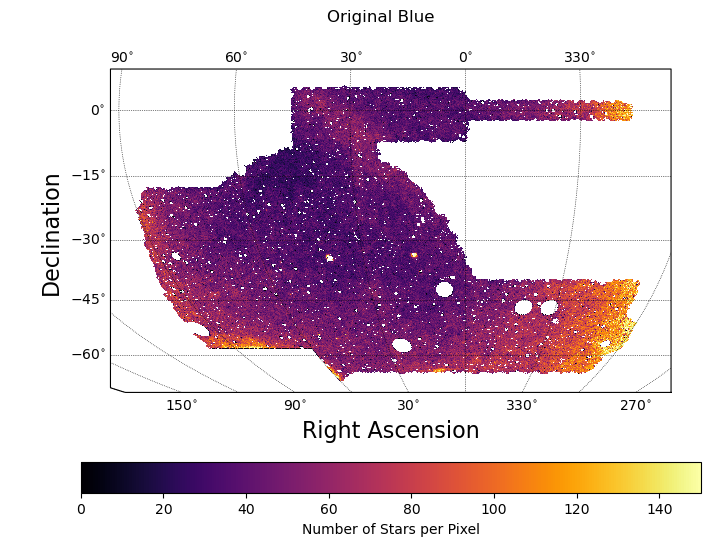

In [44]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspOrig, cmap = 'inferno')
plt.clim(0, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original Blue')
plt.show()

In [45]:
150 * np.sum(corrStar) / np.sum(origStar)

8.945462875636268

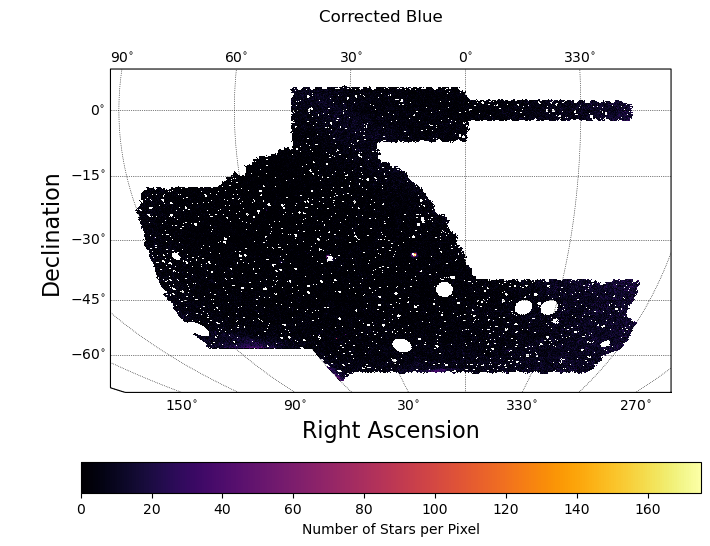

In [46]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspCorr, cmap = 'inferno')
plt.clim(0, 175)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Blue')
plt.show()

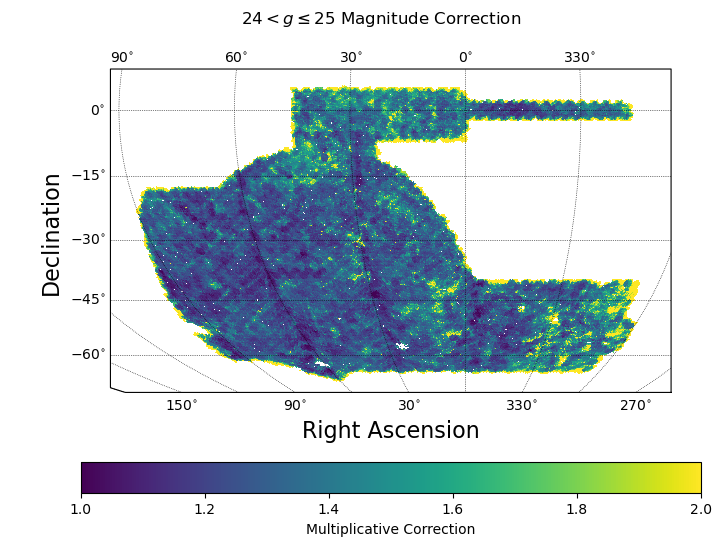

In [47]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspProbMap)
plt.clim(1, 2)
plt.colorbar(location = 'bottom', label = 'Multiplicative Correction')
fig.suptitle(r'$24<g\leq 25$ Magnitude Correction')
plt.show()

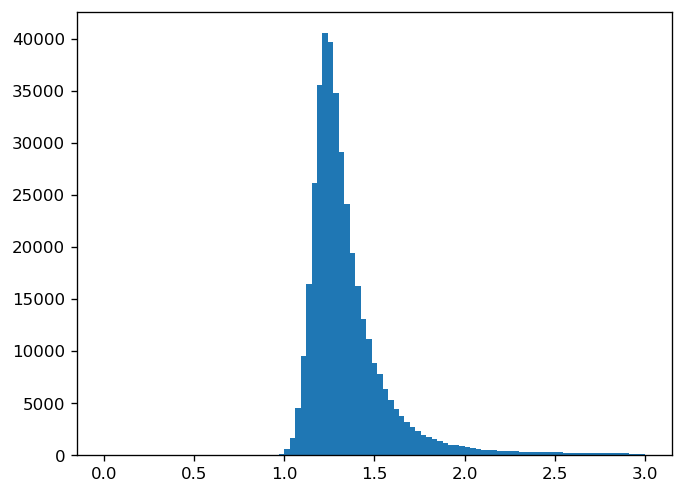

In [48]:
plt.figure(dpi = 120)
plt.hist(1/starDetProb[4], bins = np.linspace(0,3,100))
plt.show()

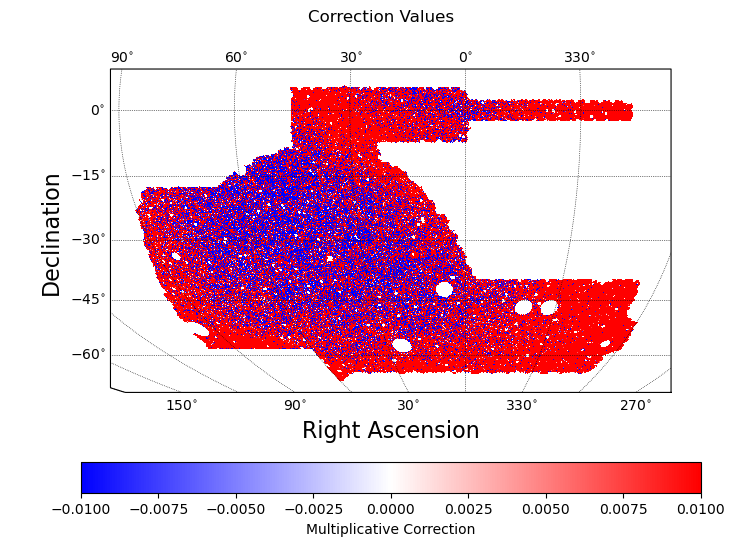

In [49]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspCorrections, cmap = 'bwr')
plt.clim(-.01, .01)
plt.colorbar(location = 'bottom', label = 'Multiplicative Correction')
fig.suptitle('Correction Values')
plt.show()

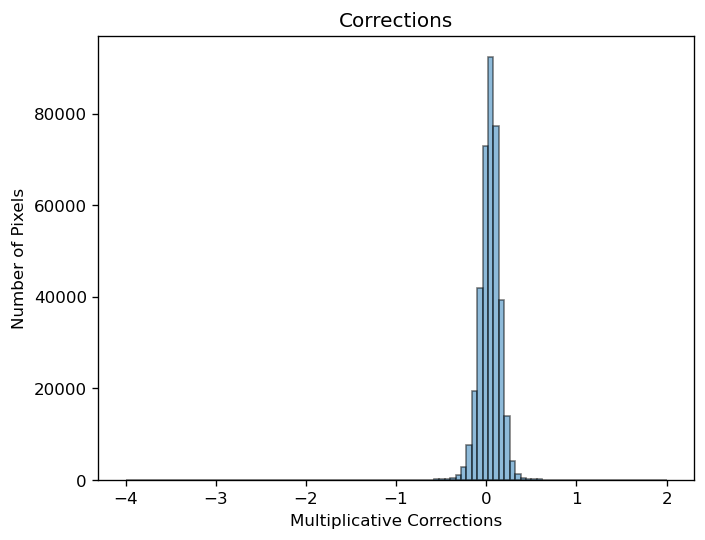

In [50]:
plt.figure(dpi = 120)
plt.hist(fullCorrs[validPix[np.where(origStar > 0)[0]]], bins = np.linspace(-4, 2, 101), alpha = 0.5, edgecolor = 'black', linewidth = 1)
plt.title('Corrections')
plt.xlabel('Multiplicative Corrections')
plt.ylabel('Number of Pixels')
plt.show()

In [51]:
corrNumbers = fullCorrs[validPix[np.where(origStar > 0)[0]]]

print(len(np.where(corrNumbers < 0)[0]) / len(corrNumbers))

0.3167249843673084


In [52]:
print(np.min(corrStar))
print(np.max(corrStar))
print(np.average(corrStar))

-12.544740368047409
495.74838809973556
2.7251323076425136


In [53]:
print(np.min(origStar))
print(np.max(origStar))
print(np.average(origStar))

0.0
1058.0
45.69577358145396


In [54]:
# my_table = Table()
# my_table['PIX'] = validPix[np.where(origStar > 0)[0]]
# my_table['CORRECTION'] = fullCorrs[validPix[np.where(origStar > 0)[0]]]
# my_table.write(galaDir + 'Star_Correction_<24.fits', overwrite = True)

In [55]:
randNeg = np.array(np.where(corrStar < 0)[0])
np.random.shuffle(randNeg)
randNeg = randNeg[0]

randPos = np.array(np.where(corrStar > 0)[0])
np.random.shuffle(randPos)
randPos = randPos[0]

In [56]:
for i in np.arange(6):
    print(obsStar[i][randNeg])

6.0
8.0
5.0
7.0
15.0
7.0


In [57]:
for i in np.arange(6):
    print(starCorrProb[i][randNeg])

0.9989186683313177
0.9777097801673521
0.9439941583551685
0.8663749876491154
0.5647787826133827
0.43344894611949036


In [58]:
for i in np.arange(6):
    print(obsGala[i][randNeg])

2.0
15.0
41.0
175.0
248.0
99.0


In [59]:
for i in np.arange(6):
    print(galaCorrProb[i][randNeg])

0.9363581201161152
0.957475976300173
0.9774566902840092
0.9610490982400572
0.8913086384933763
0.835609631221119


In [60]:
for i in np.arange(6):
    print(obsStar[i][randPos])

3.0
6.0
7.0
14.0
17.0
5.0


In [61]:
for i in np.arange(6):
    print(starCorrProb[i][randPos])

0.9976708689475433
0.9822987027466263
0.9430589994677642
0.8346004511350504
0.5112058864301372
0.39950776644930835


In [62]:
for i in np.arange(6):
    print(obsGala[i][randPos])

11.0
29.0
71.0
197.0
255.0
53.0


In [63]:
for i in np.arange(6):
    print(galaCorrProb[i][randPos])

0.947663210743425
0.9570531375735642
0.9756979977793404
0.9656401491736162
0.9166968836472763
0.8489089283445077
